In [218]:

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data


In [219]:
import yfinance as yahooFinance
from statsmodels.tsa.seasonal import seasonal_decompose 


In [220]:
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

In [221]:
BitcoinData = yahooFinance.Ticker("BTC-USD")
BitcoinData.info

{'name': 'Bitcoin',
 'startDate': 1278979200,
 'description': 'Bitcoin (BTC) is a cryptocurrency launched in 2010. Users are able to generate BTC through the process of mining. Bitcoin has a current supply of 19,711,606. The last known price of Bitcoin is 67,281.79105301 USD and is down -0.37 over the last 24 hours. It is currently trading on 11108 active market(s) with $36,161,214,669.41 traded over the last 24 hours. More information can be found at https://bitcoin.org/.',
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 68243.1,
 'open': 68243.1,
 'dayLow': 66379.49,
 'dayHigh': 68365.78,
 'regularMarketPreviousClose': 68243.1,
 'regularMarketOpen': 68243.1,
 'regularMarketDayLow': 66379.49,
 'regularMarketDayHigh': 68365.78,
 'volume': 30080499712,
 'regularMarketVolume': 30080499712,
 'averageVolume': 32668011787,
 'averageVolume10days': 27978127732,
 'averageDailyVolume10Day': 27978127732,
 'marketCap': 1313830076416,
 'fiftyTwoWeekLow': 24797.168,
 'fiftyTwoWeekHigh': 73750.

In [222]:
from sktime.transformations.series.detrend import STLTransformer

def plot_decompose(data, period):
    
    fig, axis = plt.subplots(4, figsize=(15,10))
    
    stl_transformer = STLTransformer(
        sp = period
    )
    
    stl_transformer.fit(data)
    
    data.plot(ax=axis[0], title = "Original Data")
    stl_transformer.trend_.plot(ax=axis[1], title="Trend")
    stl_transformer.seasonal_.plot(ax=axis[2], title="Seasonal")
    stl_transformer.resid_.plot(ax=axis[3], title="Residual")
    
    return stl_transformer

In [223]:
df = (BitcoinData.history(period="5y"))
df = df.sort_values('Date')

df.head()

Open         High          Low        Close  \
Date                                                                            
2019-06-13 00:00:00+00:00  8145.545410  8311.567383  8087.061035  8230.923828   
2019-06-14 00:00:00+00:00  8230.898438  8710.636719  8183.393066  8693.833008   
2019-06-15 00:00:00+00:00  8689.746094  8859.127930  8618.395508  8838.375000   
2019-06-16 00:00:00+00:00  8841.440430  9335.867188  8814.556641  8994.488281   
2019-06-17 00:00:00+00:00  8988.923828  9416.407227  8988.923828  9320.352539   

                                Volume  Dividends  Stock Splits  
Date                                                             
2019-06-13 00:00:00+00:00  18669407147        0.0           0.0  
2019-06-14 00:00:00+00:00  19831162906        0.0           0.0  
2019-06-15 00:00:00+00:00  18371033226        0.0           0.0  
2019-06-16 00:00:00+00:00  23348550311        0.0           0.0  
2019-06-17 00:00:00+00:00  15562951919        0.0           0.0

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='avg_price'>)

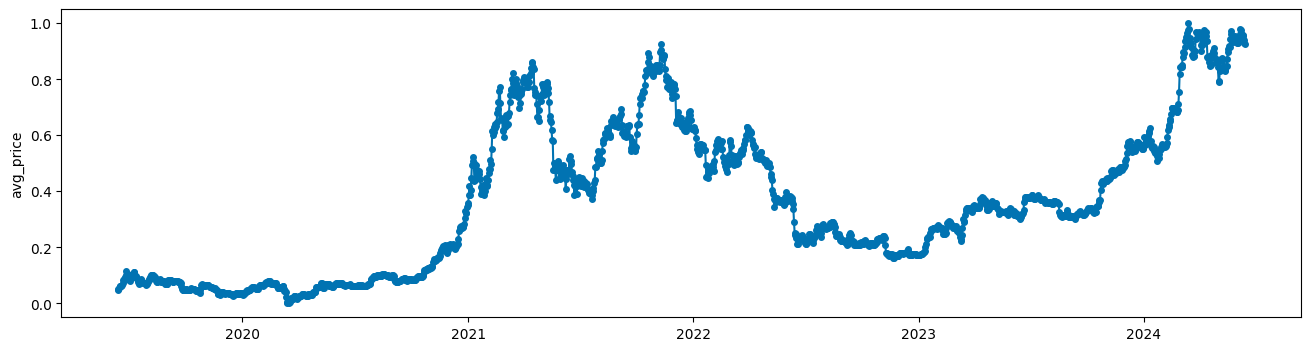

In [279]:


df["avg_price"] = (df["Low"] + df["High"]) / 2

price_series = df["avg_price"]
price_series.index = pd.to_datetime(price_series.index)


X_min = price_series.min()
X_max = price_series.max()

# Scale the data to range [0, 1]
price_series = (price_series - X_min) / (X_max - X_min)

plot_series(price_series)

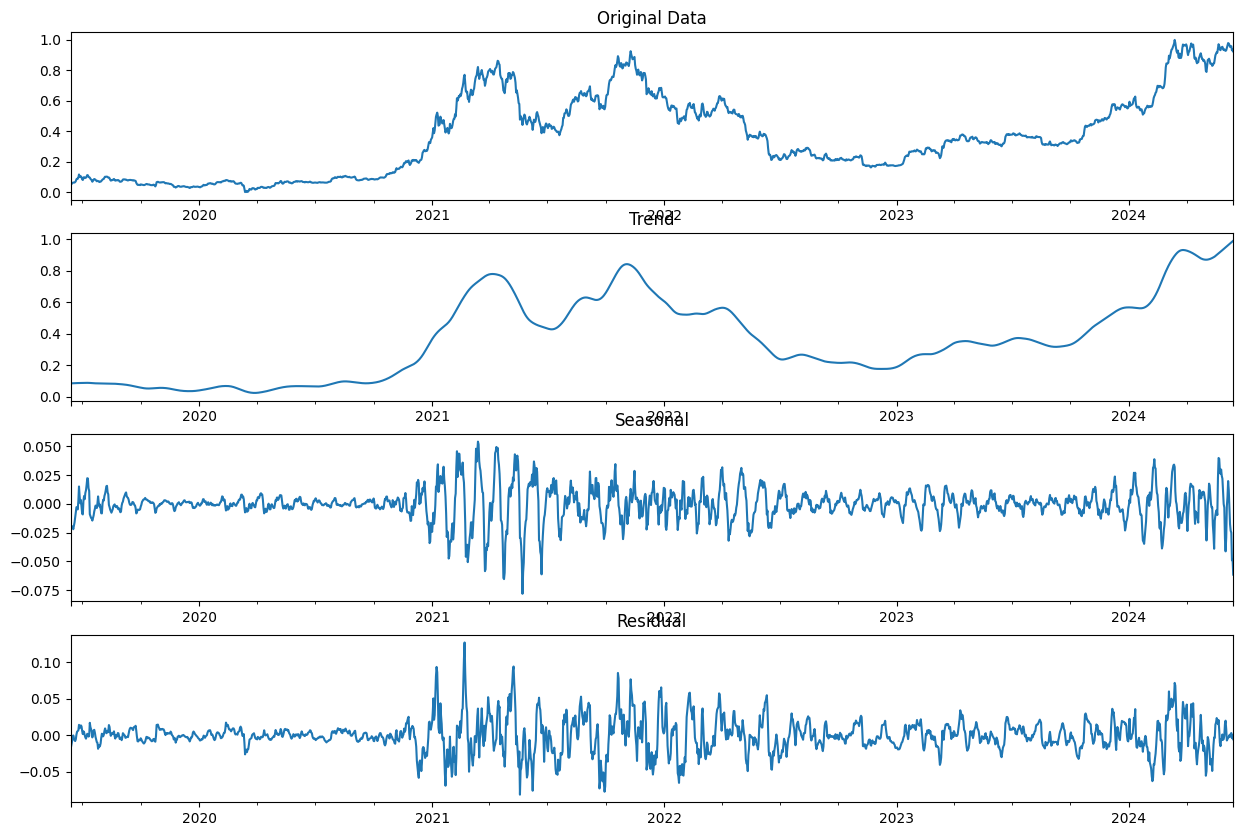

In [280]:
stl_transformer = plot_decompose(price_series, 30)

In [169]:
seasonal_period = 30

In [335]:
from scipy.stats import anderson
from sktime.forecasting.model_evaluation import evaluate
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteScaledError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanSquaredError,
)
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from statsmodels.stats.diagnostic import acorr_ljungbox


def evaluate_model(
    model,
    data: pd.Series,
    horizon: int = 1,
    plot_forecasts: bool = False,
    analyze_residuals: bool = False,
) -> None:
    cv = ExpandingWindowSplitter(initial_window=int(len(data) * 0.8), fh = horizon)
    metrics = [
        MeanAbsoluteError(),
        MeanAbsolutePercentageError(),
        MeanAbsoluteScaledError(),
        MeanSquaredError(),
    ]
    results = evaluate(model, cv, data, return_data=True, scoring=metrics) 

    # extract and print metrics
    mae = results["test_MeanAbsoluteError"]
    smape = results["test_MeanAbsolutePercentageError"]
    mase = results["test_MeanAbsoluteScaledError"]
    rmse = results["test_MeanSquaredError"]

    print(f"Mean Absolute Error: {mae.mean():.2f}")
    print(f"Mean Absolute Percentage Error: {smape.mean():.2f}")
    print(f"Mean Absolute Scaled Error: {mase.mean():.2f}")
    print(f"Mean SquaredError: {rmse.mean():.2f}")
    

    y_pred = pd.concat(results["y_pred"].values)

    if plot_forecasts:
        y_true = data[y_pred.index]
        plot_series(data, y_pred, labels=["y", "y_pred"])
        plt.figure(figsize=(25, 15))
        plt.show()
        plt.clf()
    
    if analyze_residuals:
        residuals = data - y_pred
        residuals = residuals.dropna()
        residuals.hist(bins=30)
        plt.title("Histogram of residuals")
        plt.show()
        plt.clf()

        result = anderson(residuals)
        print(f"Anderson-Darling test: {result.fit_result.success}")

        result = acorr_ljungbox(residuals, lags=10)
        print(f"Ljung-Box test: {result}")

In [282]:
from sklearn.model_selection import train_test_split
price_series= price_series.asfreq('B')
y_train, y_test = train_test_split(price_series, test_size=0.2, shuffle=False)

/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:886: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh._freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/utils/seasonality.py:173: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.index = df.index.

Mean Absolute Error: 0.10
Mean Absolute Percentage Error: 0.16
Mean Absolute Scaled Error: 10.19
Mean SquaredError: 0.02


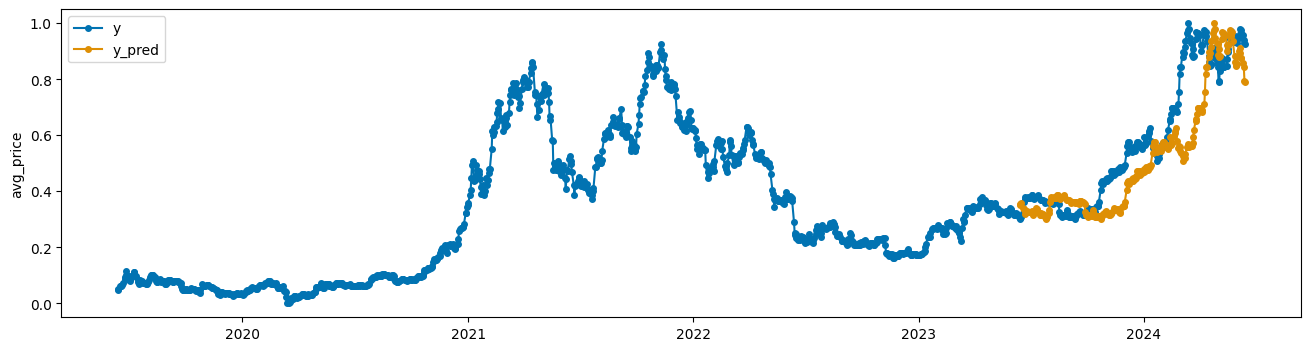

<Figure size 2500x1500 with 0 Axes>

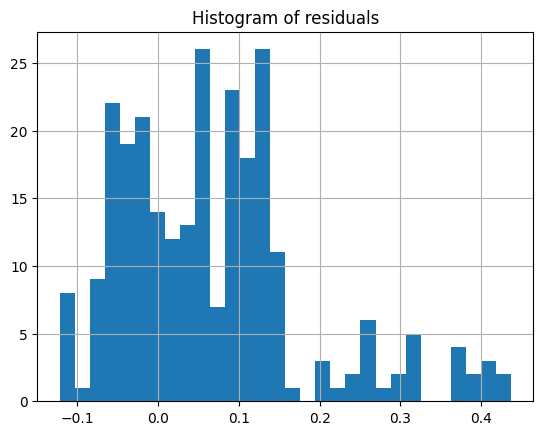

Anderson-Darling test: True
Ljung-Box test:         lb_stat      lb_pvalue
1    254.183641   3.179786e-57
2    494.227847  4.783949e-108
3    720.199568  8.748211e-156
4    929.664601  6.224814e-200
5   1122.066868  2.224759e-240
6   1297.742057  3.338245e-277
7   1458.001392  1.085810e-310
8   1603.396653   0.000000e+00
9   1733.112751   0.000000e+00
10  1847.737224   0.000000e+00


<Figure size 640x480 with 0 Axes>

In [336]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_evaluation import evaluate
from sklearn.metrics import mean_squared_error
naive_forecaster = NaiveForecaster(strategy="last", sp=seasonal_period)

naive_forecaster.fit(price_series)
evaluate_model(naive_forecaster, price_series, 1, True, True)

/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:886: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh._freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_perio

Mean Absolute Error: 0.26
Mean Absolute Percentage Error: 0.36
Mean Absolute Scaled Error: 26.89


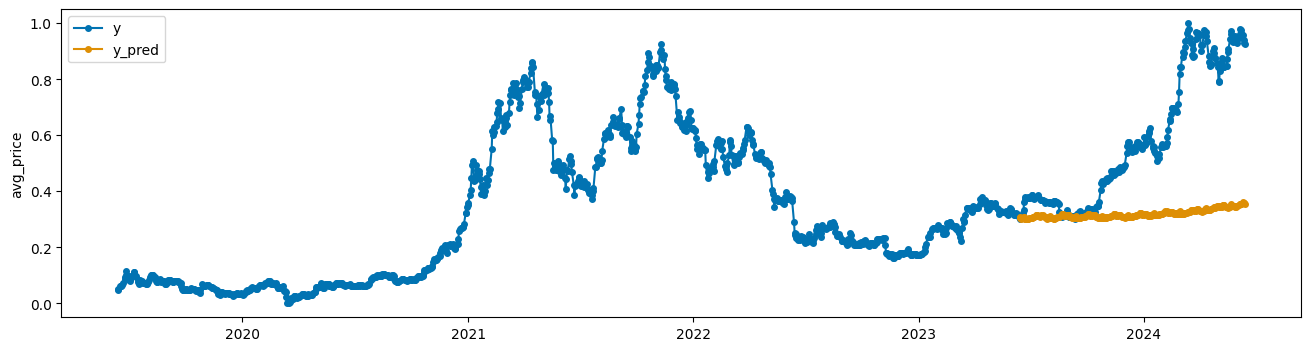

<Figure size 2500x1500 with 0 Axes>

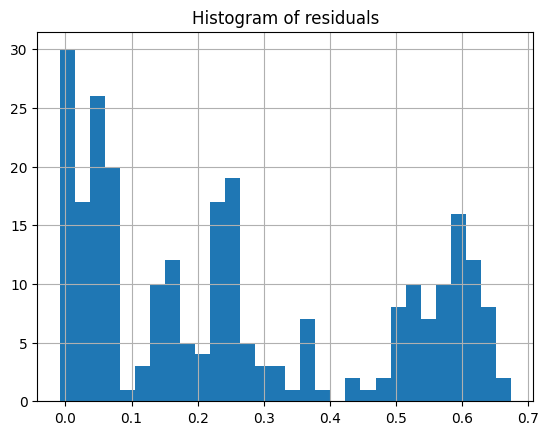

Anderson-Darling test: True
Ljung-Box test:         lb_stat      lb_pvalue
1    260.193831   1.556918e-58
2    515.492647  1.153968e-112
3    765.873492  1.089605e-165
4   1011.038235  1.446880e-217
5   1251.266243  2.306067e-268
6   1486.911544   0.000000e+00
7   1718.557086   0.000000e+00
8   1946.407656   0.000000e+00
9   2170.312538   0.000000e+00
10  2390.251420   0.000000e+00


<Figure size 640x480 with 0 Axes>

In [284]:
naive_forecaster = NaiveForecaster(strategy="mean", sp=seasonal_period)

naive_forecaster.fit(price_series)
evaluate_model(naive_forecaster, price_series, 1, True, True)

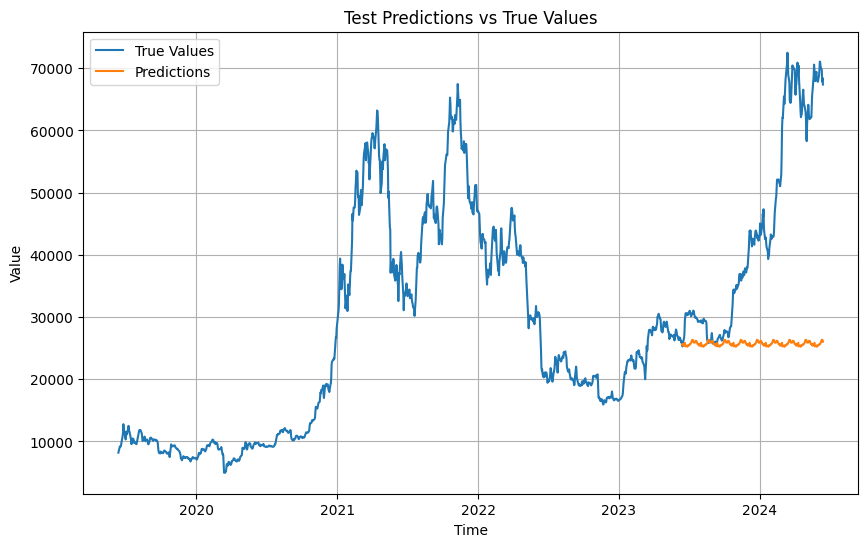

In [265]:
plt.figure(figsize=(10, 6))
plt.plot(price_series.index, price_series, label='True Values')
plt.plot(y_pred.index, y_pred, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Test Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:886: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh._freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_perio

Mean Absolute Error: 0.03
Mean Absolute Percentage Error: 0.04
Mean Absolute Scaled Error: 2.64


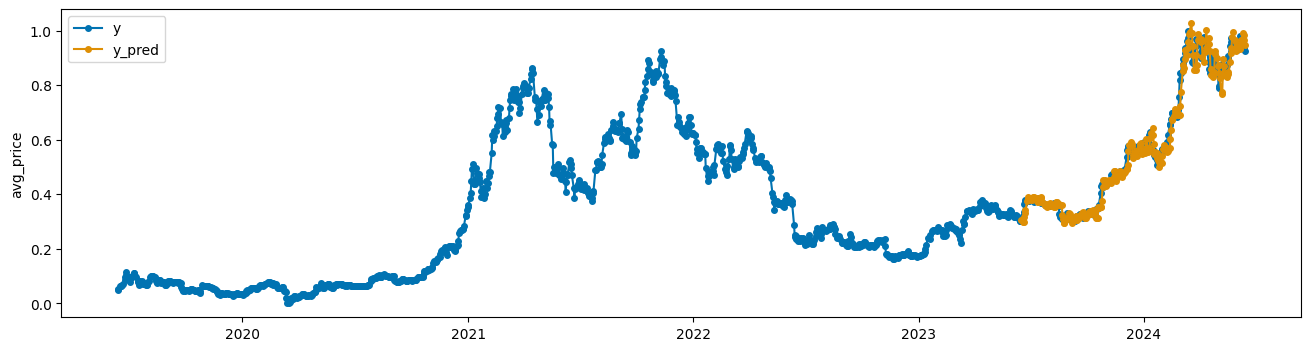

<Figure size 2500x1500 with 0 Axes>

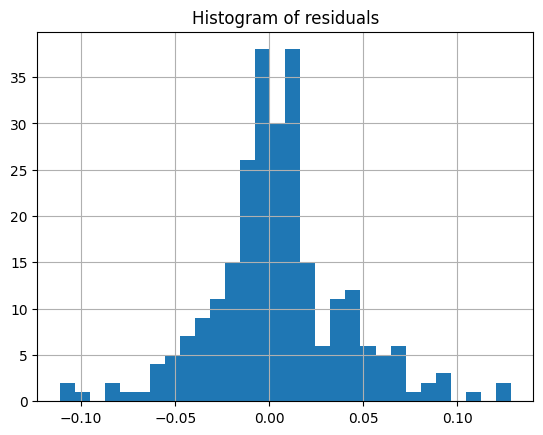

Anderson-Darling test: True
Ljung-Box test:        lb_stat     lb_pvalue
1   130.147456  3.804399e-30
2   147.506235  9.320260e-33
3   153.179107  5.431594e-33
4   178.005096  1.999582e-37
5   205.314681  2.071393e-42
6   224.773673  9.980357e-46
7   227.888471  1.394283e-45
8   229.434181  3.900675e-45
9   241.770782  5.438226e-47
10  266.785710  1.590956e-51


<Figure size 640x480 with 0 Axes>

In [286]:
from sktime.forecasting.ets import AutoETS

ets_transformer = AutoETS(trend="add", seasonal="add", sp=seasonal_period, damped_trend=True)
ets_transformer.fit(price_series)
evaluate_model(ets_transformer, price_series, 3, True, True)

In [324]:
fh = np.arange(3)
y_pred = ets_transformer.predict(fh = fh)
y_pred_var = ets_transformer.predict_var(fh=fh)
std_dev = np.sqrt(y_pred_var)


/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:886: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh._freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_perio

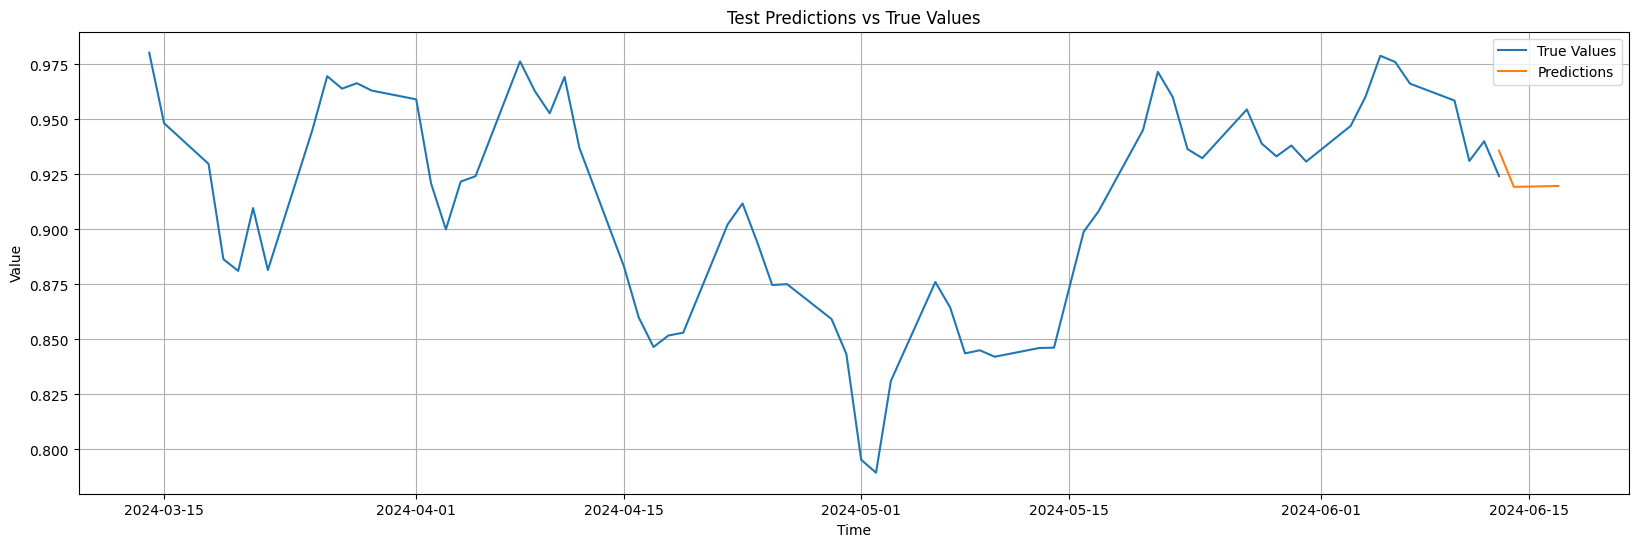

In [331]:
plt.figure(figsize=(20, 6))
y = price_series[ 19 * len(price_series) // 20:]
plt.plot(y.index, y, label='True Values')
plt.plot(y_pred.index, y_pred, label='Predictions')
# plt.errorbar(y_pred.index, y_pred, yerr=y_pred_var, fmt='o', capsize=5, label="Prediction with variance")
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Test Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:886: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh._freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_perio

Mean Absolute Error: 0.05
Mean Absolute Percentage Error: 0.08
Mean Absolute Scaled Error: 4.84


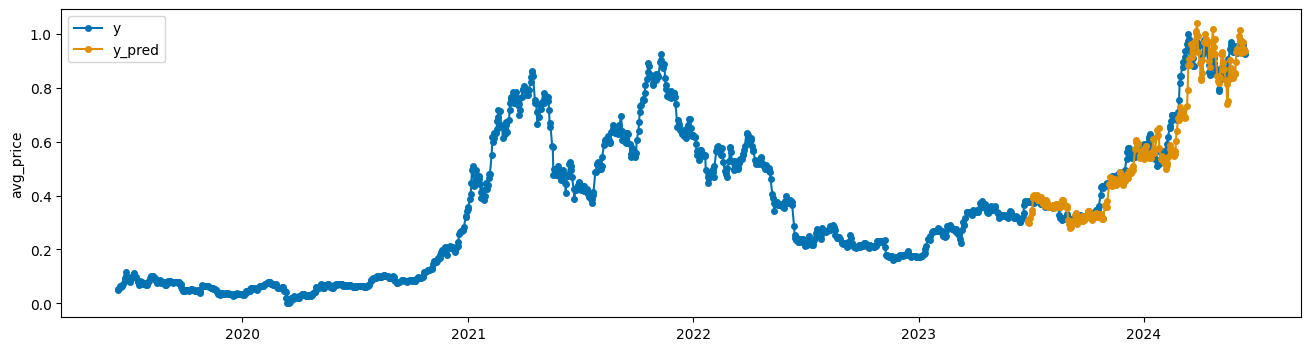

<Figure size 2500x1500 with 0 Axes>

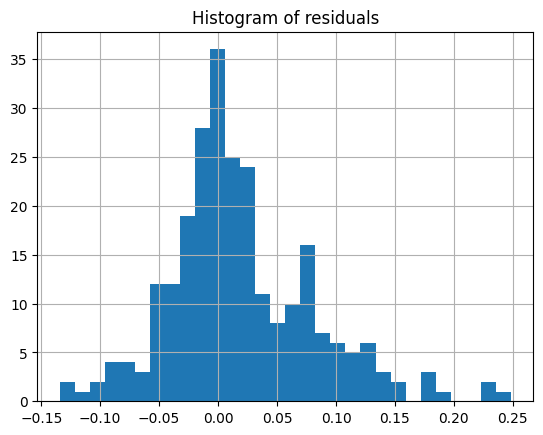

Anderson-Darling test: True
Ljung-Box test:        lb_stat      lb_pvalue
1   204.975571   1.714415e-46
2   350.362987   8.310825e-77
3   453.289757   6.316303e-98
4   523.185562  6.471150e-112
5   564.434990  9.750910e-120
6   585.205311  3.620565e-123
7   596.155739  1.638022e-124
8   600.476025  1.848759e-124
9   601.032989  1.256928e-123
10  601.053140  1.047343e-122


<Figure size 640x480 with 0 Axes>

In [332]:
ets_transformer = AutoETS(trend="add", seasonal="add", sp=seasonal_period, damped_trend=True)
ets_transformer.fit(price_series)
evaluate_model(ets_transformer, price_series, 10, True, True)

In [339]:
fh = np.arange(30)
y_pred = ets_transformer.predict(fh = fh)
y_pred_var = ets_transformer.predict_var(fh=fh)
std_dev = np.sqrt(y_pred_var)

/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:886: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh._freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_perio

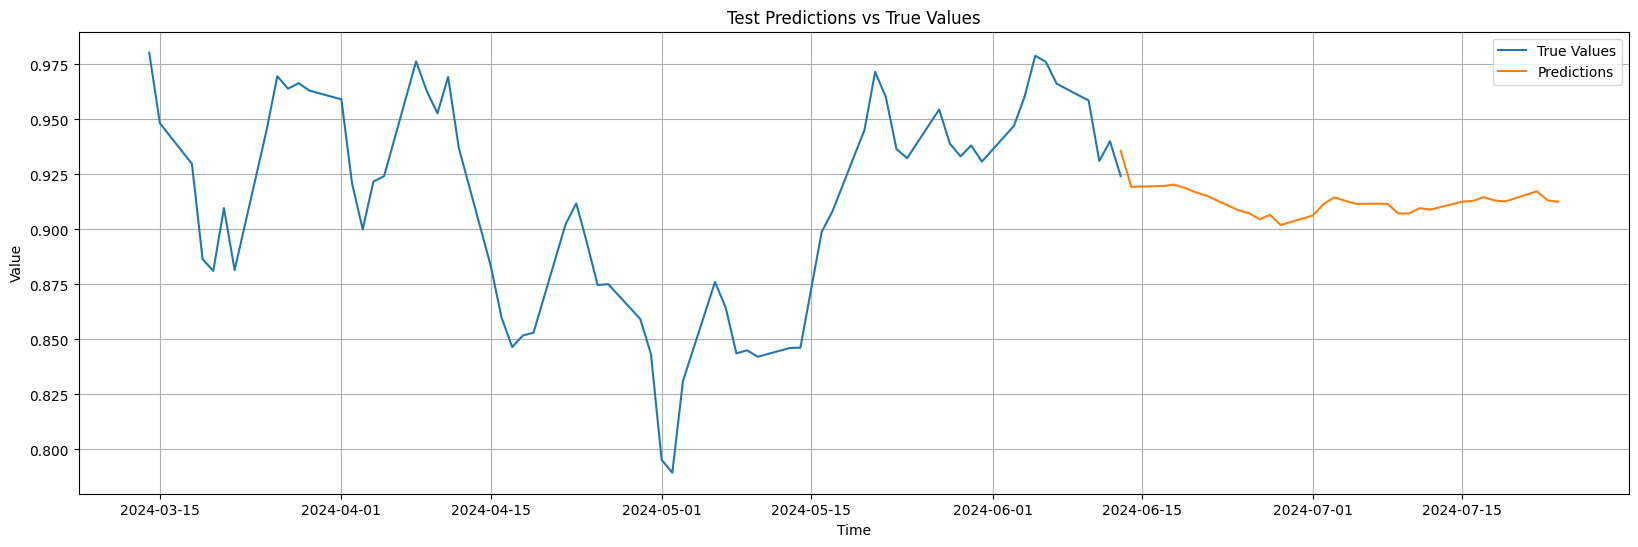

In [340]:
plt.figure(figsize=(20, 6))
y = price_series[ 19 * len(price_series) // 20:]
plt.plot(y.index, y, label='True Values')
plt.plot(y_pred.index, y_pred, label='Predictions')
# plt.errorbar(y_pred.index, y_pred, yerr=y_pred_var, fmt='o', capsize=5, label="Prediction with variance")
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Test Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:886: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh._freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_perio

Mean Absolute Error: 0.10
Mean Absolute Percentage Error: 0.16
Mean Absolute Scaled Error: 10.95
Mean SquaredError: 0.02


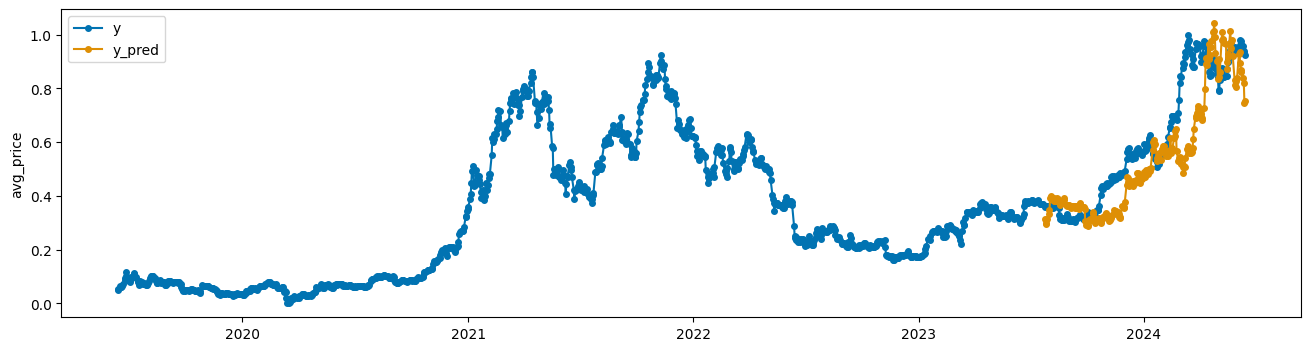

<Figure size 2500x1500 with 0 Axes>

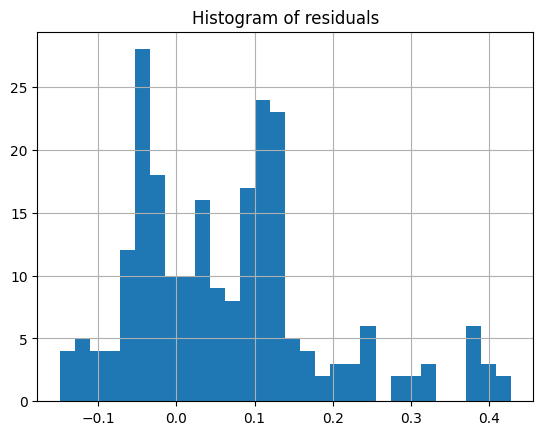

Anderson-Darling test: True
Ljung-Box test:         lb_stat      lb_pvalue
1    220.450127   7.214395e-50
2    423.939838   8.762617e-93
3    613.495917  1.195656e-132
4    785.893933  8.724458e-169
5    941.904385  2.266068e-201
6   1082.222635  1.463825e-230
7   1209.438594  6.424668e-257
8   1324.359997  1.275342e-280
9   1426.164616  1.716986e-301
10  1516.010023   0.000000e+00


<Figure size 640x480 with 0 Axes>

In [349]:
ets_transformer = AutoETS(trend="add", seasonal="add", sp=seasonal_period, damped_trend=True)
ets_transformer.fit(price_series)
evaluate_model(ets_transformer, price_series, 30, True, True)

In [350]:
fh = np.arange(30)
y_pred = ets_transformer.predict(fh = fh)
y_pred_var = ets_transformer.predict_var(fh=fh)
std_dev = np.sqrt(y_pred_var)

/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:886: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh._freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_perio

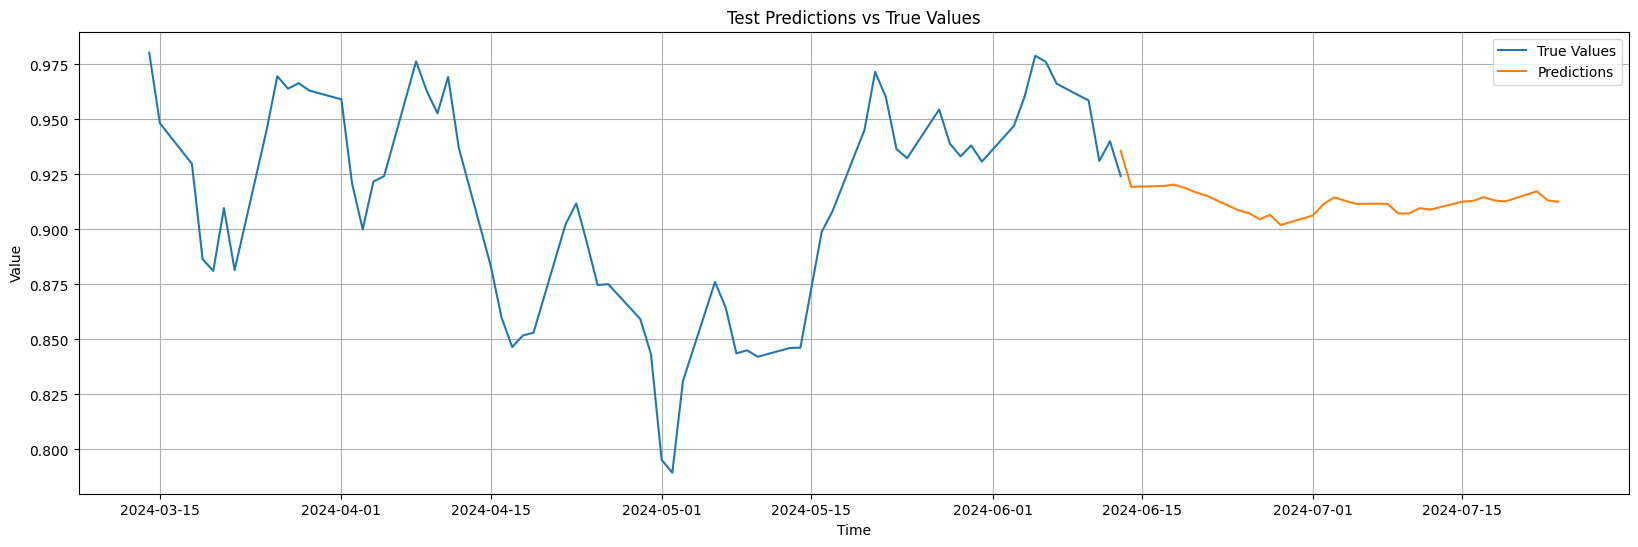

In [351]:
plt.figure(figsize=(20, 6))
y = price_series[ 19 * len(price_series) // 20:]
plt.plot(y.index, y, label='True Values')
plt.plot(y_pred.index, y_pred, label='Predictions')
# plt.errorbar(y_pred.index, y_pred, yerr=y_pred_var, fmt='o', capsize=5, label="Prediction with variance")
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Test Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters

Mean Absolute Error: 0.02
Mean Absolute Percentage Error: 0.04
Mean Absolute Scaled Error: 2.50
Mean SquaredError: 0.00


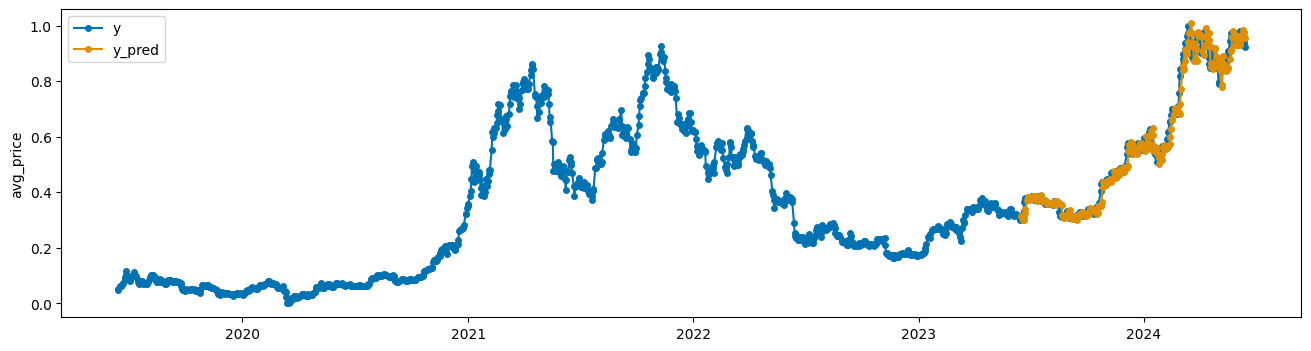

<Figure size 2500x1500 with 0 Axes>

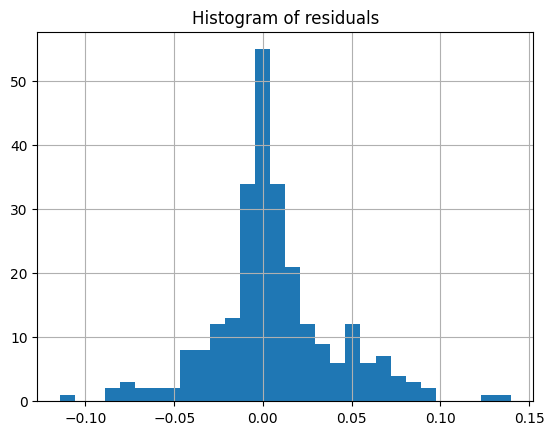

Anderson-Darling test: True
Ljung-Box test:        lb_stat     lb_pvalue
1   130.247153  3.618040e-30
2   155.548377  1.671472e-34
3   155.975260  1.354031e-33
4   164.322680  1.728641e-34
5   176.725626  2.676931e-36
6   187.264023  9.710214e-38
7   188.197020  3.609814e-37
8   191.570285  3.805888e-37
9   206.433545  1.481970e-39
10  235.279264  6.708911e-45


<Figure size 640x480 with 0 Axes>

In [345]:
from sktime.forecasting.arima import AutoARIMA

arima_forecaster = AutoARIMA(seasonal = 30)
arima_forecaster.fit(price_series)
evaluate_model(arima_forecaster, price_series, 3, True, True)

In [347]:
fh = np.arange(30)
y_pred = arima_forecaster.predict(fh = fh)
y_pred_var = arima_forecaster.predict_var(fh=fh)
#std_dev = np.sqrt(y_pred_var)

/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:886: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh._freq)
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:943: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_perio

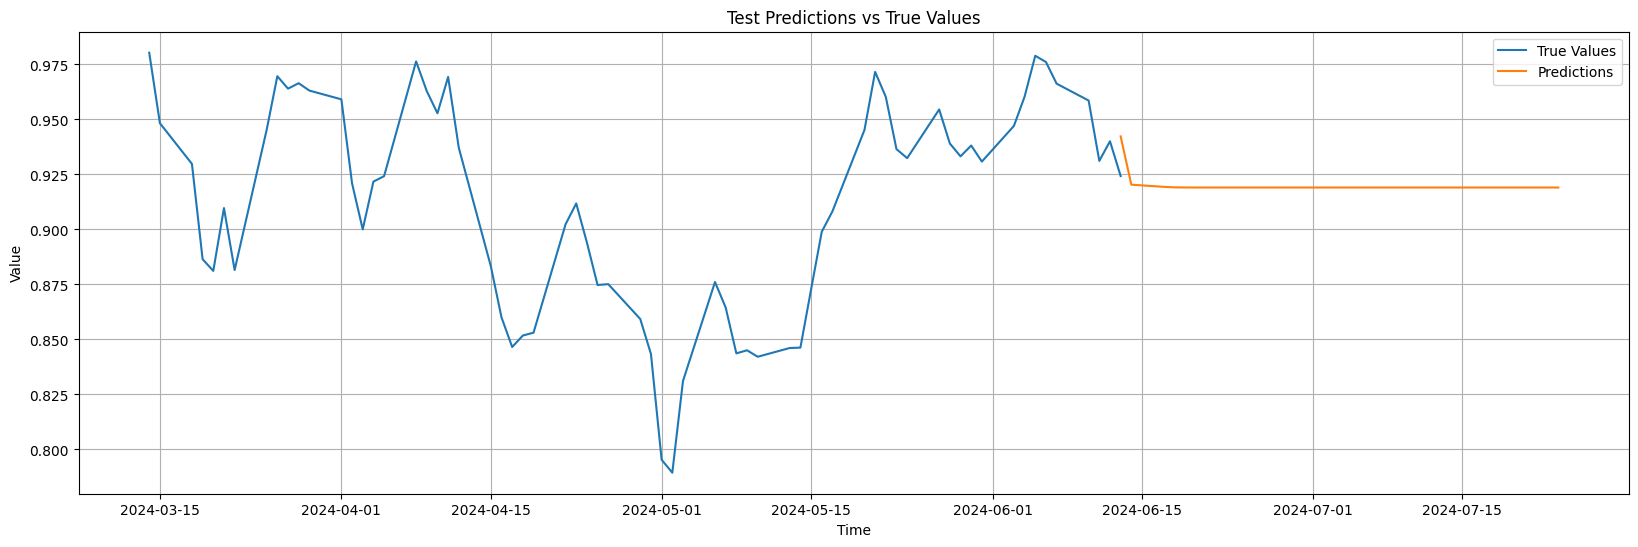

In [348]:
plt.figure(figsize=(20, 6))
y = price_series[ 19 * len(price_series) // 20:]
plt.plot(y.index, y, label='True Values')
plt.plot(y_pred.index, y_pred, label='Predictions')
# plt.errorbar(y_pred.index, y_pred, yerr=y_pred_var, fmt='o', capsize=5, label="Prediction with variance")
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Test Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jakubptak/Desktop/Projekt Bitcoin/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters

Mean Absolute Error: 0.10
Mean Absolute Percentage Error: 0.16
Mean Absolute Scaled Error: 10.93
Mean SquaredError: 0.02


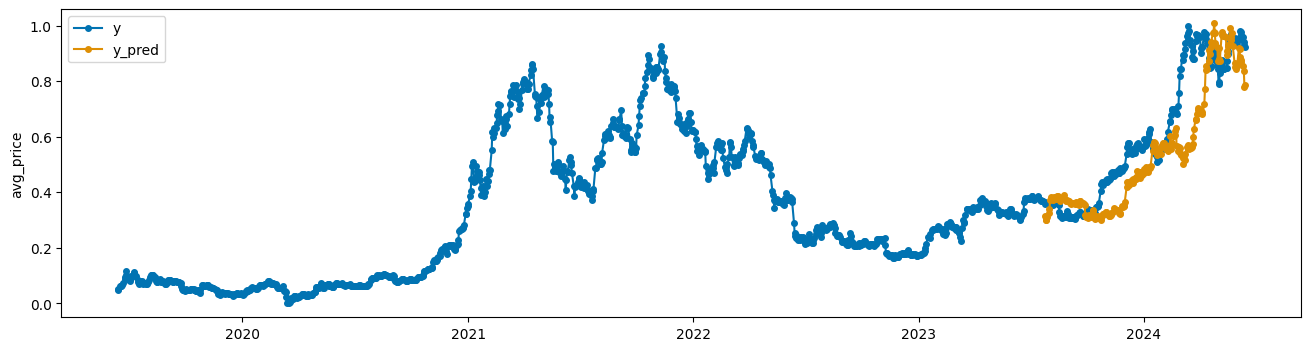

<Figure size 2500x1500 with 0 Axes>

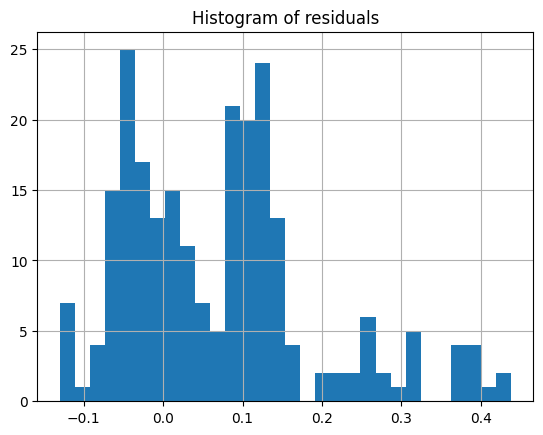

Anderson-Darling test: True
Ljung-Box test:         lb_stat      lb_pvalue
1    224.749382   8.326668e-51
2    437.968920   7.875125e-96
3    640.729930  1.490106e-138
4    829.268182  3.510859e-178
5   1003.120613  1.268450e-214
6   1161.746613  9.089845e-248
7   1306.165619  7.713424e-278
8   1436.599994  6.900116e-305
9   1552.427269   0.000000e+00
10  1654.910675   0.000000e+00


<Figure size 640x480 with 0 Axes>

In [352]:
from sktime.forecasting.arima import AutoARIMA

arima_forecaster = AutoARIMA(seasonal = 30)
arima_forecaster.fit(price_series)
evaluate_model(arima_forecaster, price_series, 30, True, True)